# Prepare Data and Model

In [1]:
import torch
import sys
import pickle
import numpy as np

sys.path.append('..')
from prosim.config.default import Config, get_config
from prosim.core.registry import registry

from prosim.demo.vis import plot_full_map, plot_batch_prompts, plot_model_output, plot_demo_fig, extract_lane_vecs
from torch.utils.data import DataLoader
from torch import tensor
nan = torch.nan

#@title Load ProSim package and util functions
import torch
import sys
import pickle
import numpy as np

from prosim.config.default import Config, get_config
from prosim.core.registry import registry

from prosim.demo.vis import plot_full_map, plot_batch_prompts, plot_model_output, plot_demo_fig, extract_lane_vecs
from torch.utils.data import DataLoader
from torch import tensor
nan = torch.nan

def modify_batch_condition(batch, type_control_nidx_dict, type_input_dict):
    all_agent_names = batch.extras['prompt']['motion_pred']['agent_ids'][0]
    controlled_agent_names = []

    if type(batch.extras['condition']) is not dict:
        batch.extras['condition'] = batch.extras['condition'].all_cond

    for ptype in type_control_nidx_dict.keys():
        control_indices = type_control_nidx_dict[ptype]
        for idx in control_indices:
            aname = all_agent_names[idx]
            if aname not in controlled_agent_names:
                controlled_agent_names.append(aname)

    if 'v_action_tag' in batch.extras['condition'].keys():
        del batch.extras['condition']['v_action_tag']

    for ptype in batch.extras['condition'].keys():
        cond_data = batch.extras['condition'][ptype]

        if ptype == 'llm_text_OneText':
            batch.extras['condition'][ptype]['mask'][0] = False
            batch.extras['condition'][ptype]['prompt_mask'][0, :] = False
            continue
        elif ptype not in type_control_nidx_dict:
            batch.extras['condition'][ptype]['mask'][0, :] = False
            batch.extras['condition'][ptype]['prompt_mask'][0, :] = False
            continue

        prompt_inputs = cond_data['input'][0]
        prompt_masks = cond_data['mask'][0, :]
        prompt_idxes = cond_data['prompt_idx'][0, :, 0]
        prompt_pmasks = cond_data['prompt_mask'][0, :]

        if ptype not in type_input_dict:
            type_input_dict[ptype] = {}

        for cidx, pidx in enumerate(prompt_idxes):
            if pidx not in type_control_nidx_dict[ptype]:
                prompt_masks[cidx] = False
                prompt_pmasks[pidx] = False
            else:
                prompt_masks[cidx] = True
                prompt_pmasks[pidx] = True
                if pidx.item() in type_input_dict[ptype]:
                    prompt_inputs[cidx] = type_input_dict[ptype][pidx.item()]
                else:
                    type_input_dict[ptype][pidx.item()] = prompt_inputs[pidx]

        batch.extras['condition'][ptype]['input'][0] = prompt_inputs
        batch.extras['condition'][ptype]['mask'][0] = prompt_masks
        batch.extras['condition'][ptype]['prompt_mask'][0] = prompt_pmasks


    for ptype in type_control_nidx_dict:
        if ptype in batch.extras['condition'].keys():
            continue
        prompt_inputs = []
        prompt_masks = []
        prompt_idx = []
        for pidx in type_control_nidx_dict[ptype]:
            prompt_inputs.append(type_input_dict[ptype][pidx])
            prompt_idx.append(pidx)
            prompt_masks.append(True)

        prompt_inputs = torch.stack(prompt_inputs)[None, :]
        # prompt_idx = torch.tensor(prompt_idx)[None, None, :]
        prompt_idx = torch.tensor(prompt_idx)[None, :]
        prompt_masks = torch.tensor(prompt_masks)[None, :]
        prompt_pmasks = torch.tensor(prompt_masks)

        batch.extras['condition'][ptype] = {}
        batch.extras['condition'][ptype]['input'] = prompt_inputs
        batch.extras['condition'][ptype]['mask'] = prompt_masks
        batch.extras['condition'][ptype]['prompt_mask'] = prompt_pmasks
        batch.extras['condition'][ptype]['prompt_idx'] = prompt_idx

    return batch, type_input_dict, controlled_agent_names

def obtain_agent_name_to_color(batch, controlled_agent_names):
    agent_name_to_color = {}

    prompt_type_to_color = {'v_action_tag': np.array([187, 152, 71]) / 255, 'goal': np.array([63, 138, 226]) / 255, 'drag_point': np.array([96, 179, 186]) / 255, 'text': (0.9677975592919913, 0.44127456009157356, 0.5358103155058701)}

    agent_name_to_color = {}

    for aname in controlled_agent_names:
        agent_name_to_color[aname] = prompt_type_to_color['text']

    return agent_name_to_color

def text_control(batch, text_input, text_idxs):
  text_control_agent_names = []

  for idx in text_idxs:
      text_aname = batch.extras['prompt']['motion_pred']['agent_ids'][0][idx]
      if text_aname not in text_control_agent_names:
          text_control_agent_names.append(text_aname)

  batch.extras['condition']['llm_text_OneText']['input'] = [text_input]
  batch.extras['condition']['llm_text_OneText']['mask'][0] = True
  batch.extras['condition']['llm_text_OneText']['prompt_mask'][0, :] = False
  for idx in text_idxs:
      batch.extras['condition']['llm_text_OneText']['prompt_mask'][0, idx] = True

  controlled_agent_names = (text_control_agent_names)

  return batch, controlled_agent_names

/u/shuhan/anaconda3/envs/ps_online/lib/python3.8/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
/u/shuhan/anaconda3/envs/ps_online/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-20 23:40:50.991514: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-20 23:40:51.137982: I tensorflow/core/util/port.cc:104] oneDNN custom op

/u/shuhan/code_release/prosim/prosim
/u/shuhan/code_release/prosim/demo_dataset


In [2]:
config = get_config('cfg/waymo_demo.yaml', cluster='local')
dataset = registry.get_dataset("prosim_imitation")(config, 'train')
all_data_index = dataset._data_index

TRAIN: use all scenes
cache location: /u/shuhan/code_release/prosim/demo_dataset/trajdata_cache
do not cache map
['goal', 'v_action_tag', 'drag_point', 'llm_text_OneText']
/u/shuhan/code_release/prosim/demo_dataset/prosim_instruct_520k_data/text_prompts/train/70b_0.8_0.9_action_prompt_v2
Condition: Loading all LLM text files from folder:  /u/shuhan/code_release/prosim/demo_dataset/prosim_instruct_520k_data/text_prompts/train/70b_0.8_0.9_action_prompt_v2


Loading LLM text files: 0it [00:00, ?it/s]

Condition: Loaded LLM text data for 0 scenes.
Loading data for matched scene tags: ['train-waymo_train']



check cached scenes (Serially): 100%|██████████| 16/16 [00:00<00:00, 53092.46it/s]

cached: 16, uncached: 0
16 scenes in the scene index.
Loaded data index from /u/shuhan/code_release/prosim/demo_dataset/trajdata_cache/data_indexes/891a1309864c26c41a7d5f6c058765b1fe119436/data_index.dill



Structuring Scene Data Index: 100%|██████████| 16/16 [00:00<00:00, 337230.47it/s]

data index already-cached, igore save_index == True).
all
TRAIN: Uniform Sample with rate: 1, sample 16 from 16 frames


# Select example and visualize ground truth

Scene ID scene_5 not found in LLM data.
DEBUG: number of condition samples in each batch: [21]
DEBUG: number of condition samples in each batch: [0]
DEBUG: number of condition samples in each batch: [21]
DEBUG: number of condition samples in each batch: [0]


(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='x (m)', ylabel='y (m)'>)

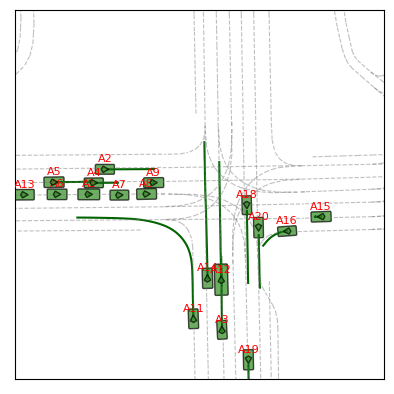

In [3]:
example_idx = 5

sample_data_index = [all_data_index[example_idx]]
dataset._data_index = sample_data_index
dataset._data_len = len(sample_data_index)

dataloader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=dataset.get_collate_fn(), num_workers=0)

for batch in dataloader:
  break

vec_map = batch.vector_maps[0]
center_in_world_xyzh = batch.centered_agent_state.as_format('x,y,z,h').cpu().numpy()[0]
vis_vecs = extract_lane_vecs(vec_map, center_in_world_xyzh, 150)

plot_demo_fig(batch, controlled_names=[], vis_vecs=vis_vecs, output=None, show_all_name=True, show_gt=True)

# Load ProSim with text conditioning enabled 

### please replace LLAMA_PATH with local path

In [4]:
config = get_config('cfg/with_text.yaml', cluster='local')
full_ckpt = 'ckpt/prosim_demo_model.ckpt'
LLAMA_PATH = '/storage/Models/shuhan/Meta-Llama-3-8B-Instruct' # Replace with your local path to Meta-Llama-3-8B-Instruct huggingface model directory

config.MODEL.CONDITION_TRANSFORMER.CONDITION_ENCODER.TEXT.LLM.MODEL_PATH['LLAMA3_8B_INSTRUCT'] = LLAMA_PATH

model_cls = registry.get_model("prosim_policy_relpe_T_step_temporal_close_loop")
model = model_cls.load_from_checkpoint(full_ckpt, config=config, strict=False, map_location='cpu')

/u/shuhan/anaconda3/envs/ps_online/lib/python3.8/site-packages/lightning_fabric/utilities/cloud_io.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, 

loading llm from /storage/Models/shuhan/Meta-Llama-3-8B-Instruct...


Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


auto device map for llm!
llm loaded!
Does not add any placeholder tokens to tokenizer!
Setting pad token to eos token
configuring lora with: LoraConfig(peft_type=<PeftType.LORA: 'LORA'>, auto_mapping=None, base_model_name_or_path=None, revision=None, task_type='CAUSAL_LM', inference_mode=False, r=16, target_modules={'q_proj', 'k_proj', 'embed_tokens', 'v_proj'}, lora_alpha=0.1, lora_dropout=0.1, fan_in_fan_out=False, bias='none', use_rslora=False, modules_to_save=None, init_lora_weights=True, layers_to_transform=None, layers_pattern=None, rank_pattern={}, alpha_pattern={}, megatron_config=None, megatron_core='megatron.core', loftq_config={}, use_dora=False, layer_replication=None, runtime_config=LoraRuntimeConfig(ephemeral_gpu_offload=False))
trainable params: 11,556,864 || all params: 8,042,866,688 || trainable%: 0.1437
LORA lr: 0.001
Adapter lr: 0.001
Goal prediction lr: 0.0
Condition lr: 0.01
loading lora weight: condition_transformers.policy_decoder.text_attn.llm_model.base_model.m

/u/shuhan/anaconda3/envs/ps_online/lib/python3.8/site-packages/pytorch_lightning/core/saving.py:161: UserWarning: Found keys that are in the model state dict but not in the checkpoint: ['condition_transformers.policy_decoder.text_attn.llm_model.base_model.model.model.embed_tokens.base_layer.weight', 'condition_transformers.policy_decoder.text_attn.llm_model.base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight', 'condition_transformers.policy_decoder.text_attn.llm_model.base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight', 'condition_transformers.policy_decoder.text_attn.llm_model.base_model.model.model.layers.0.self_attn.v_proj.base_layer.weight', 'condition_transformers.policy_decoder.text_attn.llm_model.base_model.model.model.layers.0.self_attn.o_proj.weight', 'condition_transformers.policy_decoder.text_attn.llm_model.base_model.model.model.layers.0.mlp.gate_proj.weight', 'condition_transformers.policy_decoder.text_attn.llm_model.base_model.model.model.la

# ProSim - Unconditional Rollout

no valid text


(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='x (m)', ylabel='y (m)'>)

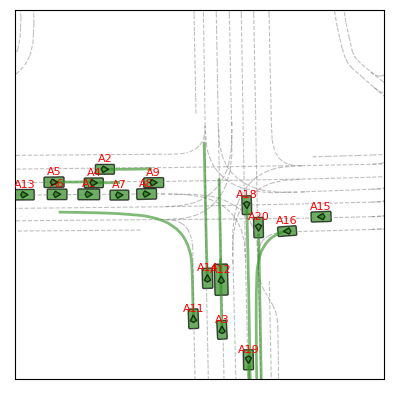

In [5]:
# unconditional rollout
batch = modify_batch_condition(batch, {}, {})[0]
batch.extras['condition']['llm_text_OneText']['mask'][0] = False
output = model.forward(batch, 'val')['motion_pred']
plot_demo_fig(batch, controlled_names=[], vis_vecs=vis_vecs, output=output, show_all_name=True, agent_name_to_color={})

## In the example above, all agents are controlled by ProSim without any prompt condition.



# ProSim - Text Control

### For each text prompt, follow the following steps:

1. Identify the agent ids to control from the visualization above. Agent IDs are shown in red text on each agent bbox.
2. Set the "text_input" to the text prompt you want to use. Be sure to refer to agents with <AXX> where XX is the agent id.
3. Set the "text_idxs" to the list of agent ids you want to control (this is not used by the model, but we require it for visualization purposes).

In [6]:
text_input = "Let <A11> stop moving; make <A12> stop moving."
text_idxs = [11, 12]

batch, controlled_agent_names = text_control(batch, text_input, text_idxs)

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='x (m)', ylabel='y (m)'>)

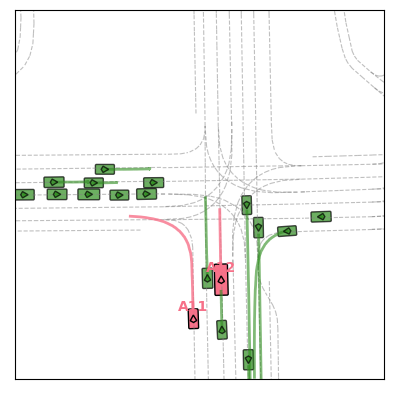

In [7]:
agent_name_to_color = obtain_agent_name_to_color(batch, controlled_agent_names)
output = model.forward(batch, 'val')['motion_pred']
plot_demo_fig(batch, controlled_names=controlled_agent_names, vis_vecs=vis_vecs, output=output, show_all_name=False, agent_name_to_color=agent_name_to_color)

In [8]:
text_input = "Let <A11> stop moving. Make <A12> accelerate."
text_idxs = [11, 12]

batch, controlled_agent_names = text_control(batch, text_input, text_idxs)

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: xlabel='x (m)', ylabel='y (m)'>)

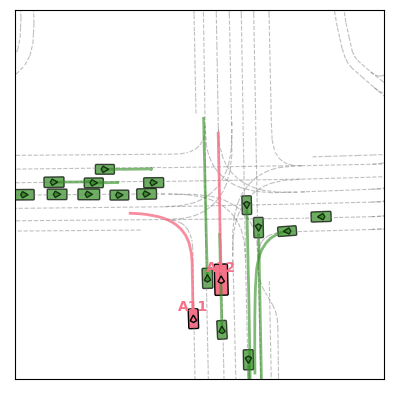

In [9]:
agent_name_to_color = obtain_agent_name_to_color(batch, controlled_agent_names)
output = model.forward(batch, 'val')['motion_pred']
plot_demo_fig(batch, controlled_names=controlled_agent_names, vis_vecs=vis_vecs, output=output, show_all_name=False, agent_name_to_color=agent_name_to_color)